### The idea here is to calculate tf-idf for all the words in Obama's speeches, then take the 100 with the highest average or 100 with highest max value, maybe cluster them, then plot them as a time series with their tf-idf values for all the speeches and see if any travel together.

In [1]:
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import warnings
import nltk
from nltk.corpus import stopwords
import en_core_web_md
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import defaultdict
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
import pprint # pretty print for easy printing of ordered dictionary
import spacy
spacy.load('en_core_web_md')
from nltk.corpus import cmudict
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download ('wordnet')
# Time series clustering
import math
# https://tslearn.readthedocs.io/en/stable/
from tslearn.clustering import TimeSeriesKMeans
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

2023-04-19 08:18:53.797394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 08:18:53.969113: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /home/muddy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/muddy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load up some speeches

In [8]:
# Load up the files
paths = ['./speeches/'] 
list_of_files = []

dates = pd.read_csv('dateSpeeches.csv')
for path in paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.txt'):
                list_of_files.append(os.path.join(root,file))

speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        #print(file)
        text = f.read()
    f.close()
    speeches.append(text)

#clean out goofy unicode  space characters 
speeches = [unicodedata.normalize("NFKD", speech) for speech in speeches if len(speech)>0 ]

# remove [stuff] in between square brackets
def remove_bracket(text):
    return re.sub('(\[[^w]*\]\s)', '',text)
speeches = [remove_bracket(speech) for speech in speeches]

# lemmatize text with spacy
nlp = spacy.load("en_core_web_md", exclude=["parser", "ner"])
for i, doc in enumerate(nlp.pipe(speeches)):
    words_lemmas_list = [token.lemma_ for token in doc]
    speeches[i]= ' '.join(words_lemmas_list)
    
# Remove punctuation - only care about words here
speeches = [re.sub(r'[^\w\s]', '', speech) for speech in speeches]

# remove numbers
speeches = [re.sub(r'\d', '', speech) for speech in speeches]

# Clean up whitespace
speeches = [re.sub('[\s+]', ' ', speech) for speech in speeches]
    
# Combine speeches and filenames
speeches = list(zip(speeches, list_of_files))
    
def get_source(text):
    regex = "[^./][a-zA-Z]+[^/]"
    string = re.findall(regex, str(text))[0]
    if string == 'speeches': string = 'oba'
    if string == 'NYTimes': string = 'nyt'
    return string.lower()

def get_date(text):
    regex = "([0-9]+[\-][0-9]+[\-][0-9]+)"
    return re.findall(regex, str(text))[0]

def get_filename(text):
    regex = "[-]([a-zA-Z]+)"
    return re.findall(regex, str(text))[0]

cols = ['text', 'filepath']
text_df = pd.DataFrame(speeches, columns=cols)
text_df['date'] = text_df['filepath'].apply(get_date)
text_df['date'] = pd.to_datetime(text_df['date'], format='%Y-%m-%d')
text_df['source'] = text_df['filepath'].apply(get_source)
text_df.set_index('date', inplace=True)
text_df.head(3)

text  \
date                                                            
2014-07-01  good afternoon  everybody  one year ago this m...   
2009-12-25  good morning  everybody  I want to take just a...   
2008-11-05  hello  Chicago     if there be anyone out ther...   

                                             filepath source  
date                                                          
2014-07-01      ./speeches/2014-07-01-Immigration.txt    oba  
2009-12-25  ./speeches/2009-12-25-UnderwearBomber.txt    oba  
2008-11-05     ./speeches/2008-11-05-ObamaElected.txt    oba

### <A HREF="https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html">sk-learn TfidfVectorizer</A>

In [9]:
# Run this if you want to remove stop words before creating contingency table
kaggle_file = open("./word_lists/kaggle_stopwords.txt", "r")
kaggle_data = kaggle_file.read()
kaggle_list = [word for word in kaggle_data.split('\n')]
kaggle_file.close()
my_list = ['thats', 'just', 'im', 'did', 'thing', 'mr', 'al', 'thank', 'okay', 'thank','thanks', 
           'question', 'joshua', 'president', 'obama', 'â', u'\x99s', u'\x99t', u'\x99ve', u'\x99m',u'\x99re', '\x99']
stop_list = list(set(kaggle_list) | set(my_list))
stop_words_kag = ENGLISH_STOP_WORDS.union(stop_list)

#for i in range(len(text_df)):
#        text_df['text'].iloc[i] = ' '.join([word for word in text_df['text'].iloc[i].split() if word.lower() not in stop_words])

### TF-IDF Vectorizer

In [10]:
# remove stopwords
stop_words = set(stopwords.words('english'))
stop_words = list(set(stop_words) | set(stop_list))
# Run TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.9)
tfidf_matrix = vectorizer.fit_transform(text_df['text'])

/home/muddy/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['come', 'vis', 'viser', 'visest'] not in stop_words.
  warnings.warn(


In [11]:
# SKIP THIS for now, the next cell is more helpful. Maybe delete this
#doc = 1
#feature_names = vectorizer.get_feature_names_out()
#feature_index = tfidf_matrix[doc,:].nonzero()[1]
#tfidf_scores = zip(feature_index, [tfidf_matrix[doc, x] for x in feature_index])
#for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
#  print(w, s)

### Resulting tf-idf dataframe: rows are speeches, columns are words

In [12]:
df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())
# df is roughly (101, 8113) unless I add more text cleanup, like removing stop words
df.head()

aaa  aaron  abadi  abandon  abbas  abbott  abbottabad  abend     abide  \
0  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   
1  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.038475   
2  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   
3  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   
4  0.0    0.0    0.0      0.0    0.0     0.0         0.0    0.0  0.000000   

   ability  ...  youtube  zacarias  zag  zardari  zeejah  zegart  zero  zig  \
0      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
1      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
2      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
3      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   
4      0.0  ...      0.0       0.0  0.0      0.0     0.0     0.0   0.0  0.0   

   zimbabweans  zimmerman  
0          0.0        0.0  
1          0.0        0.0  
2          0.0        0.0  
3          0.0        0.0  
4          0.0        0.0  

[5 rows x 7919 columns]

### Find optimal number of clusters. First cell uses sklearn, second uses tslearn

### Comment out unwanted column selection methods. 'max' selects the columns with the highest maximum tf-idf value. 'mean' selects the columns with the highest mean tf-idf values. 'non-zero' selects the columns with the most number of non-zero tf-idf values.

### Maybe the optimal number of words to look at isn't constant across the three word choosing methods???

<Axes: >

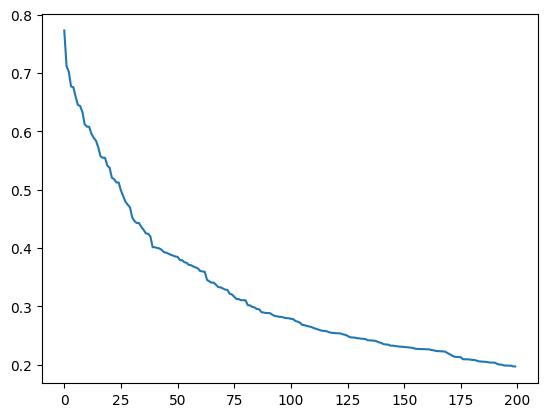

In [13]:
# Max
df.max().sort_values(ascending=False)[0:200].plot(use_index=False)

<Axes: >

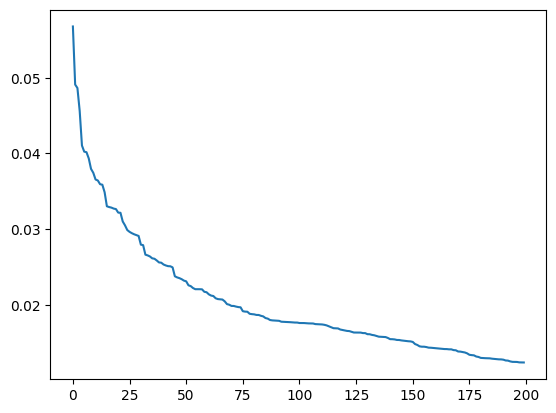

In [43]:
# Mean
df.mean().sort_values(ascending=False)[0:200].plot(use_index=False)

<Axes: >

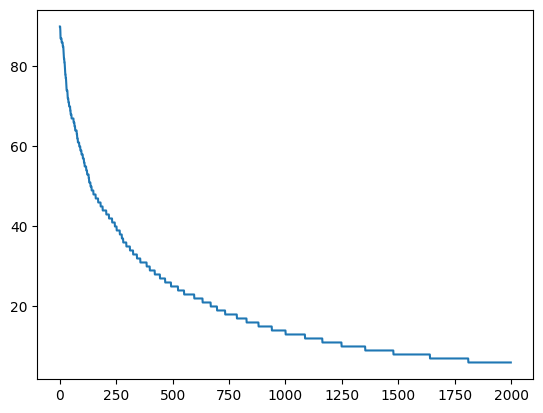

In [15]:
# Number of non-zero
df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:2000].plot(use_index=False)

### Choose optimal number of clusters using scree plot, first for sklearn's kmeans algo

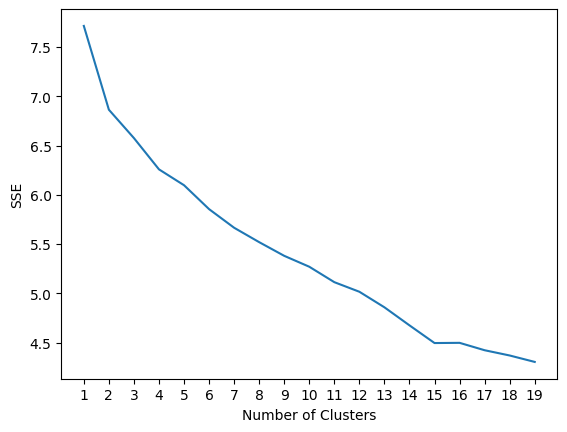

In [81]:
# for sklearn k-means algo - # max - ??? , mean - 12, nonzero - 12?
# Choose best by max value
num_words = 100
columns = df.median().sort_values(ascending=False)[0:num_words].index
# Choose best by mean value
#num_words = 100
#columns = df.mean().sort_values(ascending=False)[0:num_words].index
# Choose by number of non-zero values for each word
#num_words = 150
#columns = df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:num_words].index

subset = df[columns]
# Find number of clusters for k-means clustering
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 33,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(subset.T)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### <A HREF="https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html">TSLearn kMeans</A> k-means clustering for time series

### Choose optimal number of clusters using scree plot, now for tslearns's kmeans algo

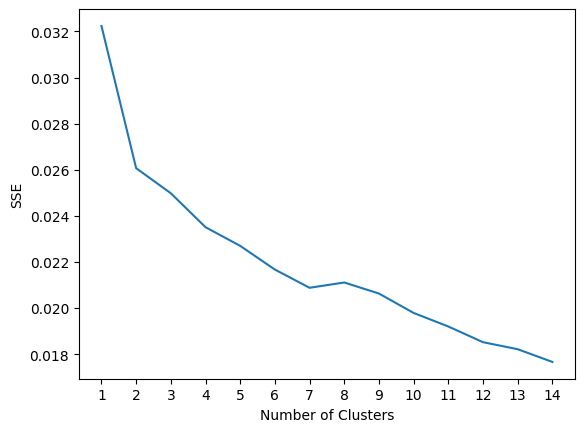

In [17]:
# for tslearn time series k-means algo - # max - 4 or 8, mean - 3 or 6, nonzero - 2 or 7
# Choose best by max value
#num_words = 80
#columns = df.max().sort_values(ascending=False)[0:num_words].index
# Choose best by mean value
#num_words = 100
#columns = df.mean().sort_values(ascending=False)[0:num_words].index
# Choose by number of non-zero values for each word
num_words = 150
columns = df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:num_words].index

subset = df[columns]
# Find number of clusters for k-means clustering

#create list to hold SSE values for each k
sse = []
for k in range(1, 15):
    tskm = TimeSeriesKMeans(n_clusters=k, random_state=33, metric="dtw")
    tskm.fit_predict(subset.T)
    sse.append(tskm.inertia_)

#visualize results
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### function to return the tf-idf values for chosen words and the cluster labels

### algo: 'skl' for sk-learn and 'ts' for tslearn
### method: 'max', 'mean', 'nonzero' as described above

In [48]:
def cluster(df, algo, method, cluster_count):
    if method == 'max':
        # Choose best by max value
        num_words = 80
        columns = df.max().sort_values(ascending=False)[0:num_words].index
    elif method == 'mean':
        # Choose best by mean value
        num_words = 100
        columns = df.mean().sort_values(ascending=False)[0:num_words].index
    elif method == 'nonzero':
        # Choose by number of non-zero values for each word
        num_words = 150
        columns = df.astype(bool).sum(axis=0).sort_values(ascending=False)[0:num_words].index
    elif method == 'median':
        # Choose by median value
        num_words = 60
        columns = df.median().sort_values(ascending=False)[0:num_words].index
    else:
        print('Choose a valid method: max, mean, median, nonzero')
        return False
    subset = df[columns]
    labelsdf = pd.DataFrame(columns=['label', 'word'])
    if algo == 'skl':
        kmeans = KMeans(n_clusters=cluster_count, **kmeans_kwargs).fit(subset.T)
        labelsdf['label'] = pd.DataFrame(list(kmeans.labels_))
    elif algo == 'ts':
        tskm = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
        labelsdf['label'] = pd.DataFrame(tskm.fit_predict(subset.T))
    else:
        print('Choose a valid algo: skl, ts')
        return False
    labelsdf['word']= list(subset.columns)
    subsetdate = subset.copy()
    subsetdate['date']= text_df.index
    reshape = subsetdate.melt(var_name='word', value_name='tfidf', id_vars=['date'])
    reshape['dateint']=reshape['date'].apply(lambda x: x.value)
    reshape = pd.merge(reshape, labelsdf, on='word', how='left')
    # remove 2004 speech to make plot look nicer
    cutoff = pd.to_datetime('2008-01-01')
    reshape = reshape.query('date>@cutoff')
    reshape.sort_values('date', inplace=True, ignore_index=True)
    return([reshape, labelsdf])

### get results for all 6 combos of method and algo

In [49]:
# for sklearn k-means algo - # max - 4 or 5, mean - 9, nonzero - 2 to 5
# for tslearn time series k-means algo - # max - 7, mean - 4, nonzero - 2 or 6
# def cluster(df, algo, method, cluster_count)
reshapemax, labelsdfmax = cluster(df, 'skl', 'max', 9)
reshapemean, labelsdfmean = cluster(df, 'skl', 'mean', 9)
reshapenonzero, labelsdfnonzero = cluster(df, 'skl', 'nonzero', 9)
reshapemedian, labelsdfmedian = cluster(df, 'skl', 'median', 9)
reshapetsmax, labelsdftsmax = cluster(df, 'ts', 'max', 7)
reshapetsmean, labelsdtsfmean = cluster(df, 'ts', 'mean', 7)
reshapetsnonzero, labelsdftsnonzero = cluster(df, 'ts', 'nonzero', 7)

/tmp/ipykernel_7793/1327901179.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7793/1327901179.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7793/1327901179.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_7793/1327901179.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

### Plots

In [50]:
plotthis = reshapemax.query('tfidf > 0.1')
fig = px.line(reshapemax, x='date', y='tfidf', color='label', hover_name='word')
fig.show()

In [83]:
fig = px.scatter(reshapemean, x="date", y="tfidf", color="label", hover_name="word", 
                 facet_col="label", trendline='ols')
fig.show()

In [82]:
fig = px.scatter(reshapemedian, x="date", y="tfidf", color="label", hover_name="word", 
                 facet_col="label", trendline='ols')
fig.show()

In [58]:
fig = px.line(reshapemedian, x='date', y='tfidf', color='label', hover_name='word')
fig.show()

### Cluster lists for the 6 methods

In [ ]:
# max sklearn
number = len(set(list(labelsdfmax['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdfmax)):
        if labelsdfmax['label'].iloc[i] == j:
            print('\t',labelsdfmax['word'].iloc[i])

In [55]:
# mean sklearn
number = len(set(list(labelsdfmean['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdfmean)):
        if labelsdfmean['label'].iloc[i] == j:
            print('\t',labelsdfmean['word'].iloc[i])

0
	 care
	 health
	 insurance
1
	 company
2
	 energy
	 oil
3
	 new
	 job
	 help
	 right
	 business
	 economy
	 pay
	 reform
	 create
	 million
	 worker
	 high
	 student
	 college
	 pass
4
	 iraq
5
	 america
	 world
	 come
	 nation
	 well
	 see
	 change
	 future
	 child
	 man
	 tonight
	 believe
	 love
6
	 want
	 need
	 say
	 like
	 family
	 way
	 think
	 give
	 let
	 keep
	 first
	 sure
	 hope
	 back
	 state
	 community
	 hard
	 still
	 happen
	 next
	 young
	 look
7
	 today
	 united
	 states
	 war
	 government
	 day
	 security
	 life
	 law
	 long
	 last
	 great
	 home
	 stand
	 effort
	 support
	 act
	 military
	 build
	 woman
	 place
	 end
	 may
	 action
	 continue
	 nuclear
	 challenge
	 fight
	 force
	 lead
	 live
	 face
	 justice
	 mean
	 generation
	 leader
	 system
	 power
	 include
	 peace
8
	 american
	 americans
	 congress


In [56]:
# median sklearn
number = len(set(list(labelsdfmedian['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdfmedian)):
        if labelsdfmedian['label'].iloc[i] == j:
            print('\t',labelsdfmedian['word'].iloc[i])

0
	 america
1
	 american
	 americans
	 care
2
	 million
	 economy
3
	 well
	 help
	 right
	 want
	 way
	 need
	 like
	 let
	 first
	 keep
	 last
	 back
	 put
	 happen
	 hard
	 look
	 community
	 sure
4
	 come
	 say
	 today
	 family
	 see
	 day
	 life
	 give
	 future
	 man
	 long
	 child
	 great
	 still
	 may
	 believe
	 woman
	 face
	 change
5
	 new
	 job
6
	 world
	 nation
7
	 government
	 states
	 united
	 security
	 place
	 lead
	 stand
	 bring
	 home
	 across
	 begin
	 fight
8
	 think


In [ ]:
# non-zero sklearn
number = len(set(list(labelsdfnonzero['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdfnonzero)):
        if labelsdfnonzero['label'].iloc[i] == j:
            print('\t',labelsdfnonzero['word'].iloc[i])

In [ ]:
# max tslearn
number = len(set(list(labelsdftsmax['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdftsmax)):
        if labelsdftsmax['label'].iloc[i] == j:
            print('\t',labelsdftsmax['word'].iloc[i])

In [ ]:
# mean tslearn
number = len(set(list(labelsdtsfmean['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdtsfmean)):
        if labelsdtsfmean['label'].iloc[i] == j:
            print('\t',labelsdtsfmean['word'].iloc[i])

In [ ]:
# non-zero tslearn
number = len(set(list(labelsdftsnonzero['label'])))
for j in range(number):
    print(j)
    for i in range(len(labelsdftsnonzero)):
        if labelsdftsnonzero['label'].iloc[i] == j:
            print('\t',labelsdftsnonzero['word'].iloc[i])